In [136]:
# packages
import gzip
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import json
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from collections import defaultdict
import time
import random
import matplotlib.pyplot as plt

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [3]:

review_filepath = "../assignment2/review-Idaho.json.gz"
meta_filepath = "../assignment2/meta-Idaho.json.gz"

reviews = []
bizs = []
for l in parse(review_filepath):
    reviews.append(l)

for l in parse(meta_filepath):
    bizs.append(l)

In [100]:
reviews_w_plus_minus_responses = [review for review in reviews if review.get("resp")]
print(len(reviews_w_plus_minus_responses))
reviews_with_responses = [review for review in reviews 
                          if ((review.get("resp")) and (review['resp']['time'] - review['time'] > 0))]
len(reviews_with_responses)

729928


700132

In [101]:
# Create new resp_time variable within each review
for r in reviews_with_responses:
    r['resp_time'] = r['resp']['time'] - r['time']

In [102]:
reviews_with_responses[0]

{'user_id': '115114032166130224762',
 'name': 'Mariah Schaeffer',
 'time': 1589989743506,
 'rating': 5,
 'text': 'Kevin and Shannon are amazing! They were very sweet and made the job fast! Also they are one of the cheeper junk removal services! I will for sure use again!',
 'pics': None,
 'resp': {'time': 1591139557205,
  'text': 'Thank you for hiring us for your junk removal!'},
 'gmap_id': '0x54afb4c19c4bffff:0x9389114191ca2781',
 'resp_time': 1149813699}

# Model #1 Baseline - Review Features

In [151]:
def baseline_feat(d):
    feat = [1]
    try:
        text_length = len(d['text'])
    except (KeyError, TypeError):
        text_length = 0 
    feat.append(text_length)
    feat.append(d.get('rating', 0))
    feat.append(d.get('time', 0))
    return feat

In [152]:
shuffle_data = reviews_with_responses.copy()
print(shuffle_data[0])
random.shuffle(shuffle_data)
print(shuffle_data[0])

start = time.time()
encodedDataXBase = [baseline_feat(r) for r in shuffle_data]
encodedDatayBase = [r['resp_time'] for r in shuffle_data]
end = time.time()
print(f"encoding time = {end-start}s")

split_spot = int(len(encodedDataXBase)*0.8)
XTrainBase = encodedDataXBase[:split_spot]
yTrainBase = encodedDatayBase[:split_spot]
XTestBase = encodedDataXBase[split_spot:]
yTestBase = encodedDatayBase[split_spot:]

#X = [baseline_feat(r) for r in reviews_with_responses]
#y = [r['resp_time'] for r in reviews_with_responses]


{'user_id': '115114032166130224762', 'name': 'Mariah Schaeffer', 'time': 1589989743506, 'rating': 5, 'text': 'Kevin and Shannon are amazing! They were very sweet and made the job fast! Also they are one of the cheeper junk removal services! I will for sure use again!', 'pics': None, 'resp': {'time': 1591139557205, 'text': 'Thank you for hiring us for your junk removal!'}, 'gmap_id': '0x54afb4c19c4bffff:0x9389114191ca2781', 'resp_time': 1149813699}
{'user_id': '114194946307142003442', 'name': 'jill joki', 'time': 1516679800460, 'rating': 2, 'text': None, 'pics': None, 'resp': {'time': 1516726995776, 'text': 'jill joki Thank you for the feedback. We will try our best to make your next visit a great one! If you would like to tell us more about your experience, please leave  your feedback here:  http://bit.ly/ContactUsGC'}, 'gmap_id': '0x53554f59a521ab65:0x63087a378a071345', 'resp_time': 47195316}
encoding time = 225.94679594039917s


In [153]:
modelBase = sklearn.linear_model.LinearRegression(fit_intercept=False)
modelBase.fit(XTrainBase, yTrainBase)

LinearRegression(fit_intercept=False)

In [154]:
y_pred_base = modelBase.predict(XTestBase)
# print(y_pred[:5], yTestBase[:5])
# print(np.array(y_pred[:5]) - np.array(yTestBase[:5])) # these are relatively low suggesting outliers
sse_base = sum([x**2 for x in (yTestBase - y_pred_base)])
mse_base = sse_base / len(yTestBase)
mse_base

1.3569407980232047e+20

In [155]:
# in days
np.sqrt(mse) / 1000 / 60 / 60 / 24

135.70175151920796

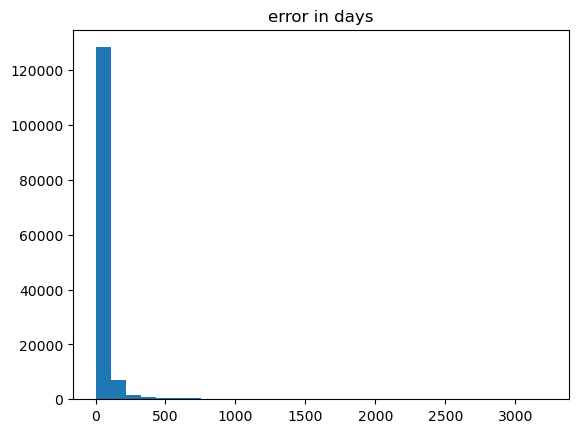

In [156]:
plt.hist([np.sqrt(x**2)/ 1000 / 60 / 60 / 24 for x in (yTestBase - y_pred_base)], bins = 30)
plt.title('error in days')
plt.show() ### shows outlier around 8 years. Is this the true y value causing it? sort and find top difference later

# Advanced Model - Business Features included

In [157]:
bizByID = defaultdict(dict)
for b in bizs:
    bizByID[b['gmap_id']] = b

In [158]:
def feat(r):
    feat = [1]
    try:
        text_length = len(r['text'])
    except (KeyError, TypeError):
        text_length = 0 
    feat.append(text_length)
    feat.append(r.get('rating', 0))
    feat.append(r.get('time', 0))

    ### Using biz
    gmap_id = r.get('gmap_id')
    #if id from review in biz IDs, get the avg review from the biz
    if gmap_id in bizByID.keys() and isinstance(bizByID[gmap_id], dict):
        avg_rating = bizByID[gmap_id].get('avg_rating', 0)
    else:
        avg_rating = 0  # Default if gmap_id is invalid or not in b
    feat.append(avg_rating)

    # relative bizs
    try:
        num_simlr_biz = len(bizByID[gmap_id].get('relative_results', 0))
    except Exception as e:
        num_simlr_biz = 0
    feat.append(num_simlr_biz)
    
    # state
    try:
        state_cat = bizByID[gmap_id].get('state').split()[0]
        if state_cat == 'Open':
            state_ohe=[0,0,0,0,0,0,1]
        elif state_cat == 'Opens':
            state_ohe=[0,0,0,0,0,1,0]
        elif state_cat == 'Closed':
            state_ohe=[0,0,0,0,1,0,0]
        elif state_cat == 'Closes':
            state_ohe=[0,0,0,1,0,0,0]
        elif state_cat == 'Permanently':
            state_ohe=[0,0,1,0,0,0,0]
        elif state_cat == 'Temporarily':
            state_ohe=[0,1,0,0,0,0,0]
        else:
            print(state_cat)
    except Exception as e:
        state_ohe=[1,0,0,0,0,0,0]
    feat += state_ohe
    return feat

In [159]:
# shuffle_data = reviews_with_responses.copy() # DEFINED ABOVE
# print(shuffle_data[0])
# random.shuffle(shuffle_data)
# print(shuffle_data[0])

start = time.time()
encodedDataX = [feat(r) for r in shuffle_data]
encodedDatay = [r['resp_time'] for r in shuffle_data]
end = time.time()
print(f"encoding time = {end-start}s")

split_spot = int(len(encodedDataX)*0.8)
XTrain = encodedDataX[:split_spot]
yTrain = encodedDatay[:split_spot]
XTest = encodedDataX[split_spot:]
yTest = encodedDatay[split_spot:]

encoding time = 73.30093216896057s


In [160]:
print(X[0], y[0])

[1, 157, 5, 1589989743506, 1149813699, 5, 4, 0, 0, 1, 0, 0, 0, 0] 1149813699


In [161]:
model2 = sklearn.linear_model.LinearRegression(fit_intercept=False)
model2.fit(XTrain, yTrain)

LinearRegression(fit_intercept=False)

In [162]:
y_pred = model2.predict(XTest)
sse = sum([x**2 for x in (yTest - y_pred)])
mse = sse / len(yTest)
mse 
# Test MSE: 
    # with: 

1.3433698385148074e+20

In [163]:
# in days
np.sqrt(mse) / 1000 / 60 / 60 / 24

134.14795426722887

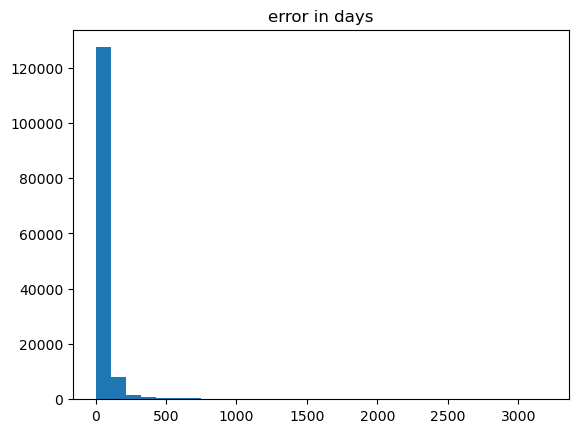

In [164]:
plt.hist([np.sqrt(x**2)/ 1000 / 60 / 60 / 24 for x in (yTest - y_pred)], bins = 30)
plt.title('error in days')
plt.show()

# Scratch

In [113]:
import numpy as np
resp_time_lst = [d['resp_time'] / 1000 / 60 / 60 / 24 for d in reviews_with_responses]
np.quantile(resp_time_lst, [0.25, 0.5, 0.75])

array([0.46475142, 1.77545962, 7.78040038])

In [59]:
#resp_time_lst

In [22]:
bizs[0]

{'name': 'Montour WMA - Idaho Fish and Game',
 'address': 'Montour WMA - Idaho Fish and Game, Montour Rd, Emmett, ID 83617',
 'gmap_id': '0x54af0dfadab474e1:0x3ae5c949132941d8',
 'description': None,
 'latitude': 43.9295808,
 'longitude': -116.3333273,
 'category': ['Hunting area'],
 'avg_rating': 4.4,
 'num_of_reviews': 17,
 'price': None,
 'hours': None,
 'MISC': {'Accessibility': ['Wheelchair accessible parking lot']},
 'state': None,
 'relative_results': ['0x54af0df970009eab:0x998e663a1d2ea45',
  '0x54af0e08fb885aed:0xf626feadb2775442',
  '0x54afa0ce7af7268b:0x4b98fe1767238dc4',
  '0x54afc0324c4ca65b:0x808e759ecacfab1c',
  '0x54afb8ee4d09b825:0x50112376cec8c0ff'],
 'url': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x54af0dfadab474e1:0x3ae5c949132941d8?authuser=-1&hl=en&gl=us'}

In [31]:
reviews[5]

{'user_id': '108480743392575424354',
 'name': 'Dan Shadix',
 'time': 1525705287828,
 'rating': 5,
 'text': 'Love this float on paddle boards.  Nice flat water and fairly slow.',
 'pics': None,
 'resp': None,
 'gmap_id': '0x54af0dfadab474e1:0x3ae5c949132941d8'}

In [47]:
business_reviews = defaultdict(lambda: None)
for r in reviews:
    if r['resp'] and 'time' in r['resp']:
        business_reviews[r['gmap_id']] = r['resp']['time'] - r['time']

In [51]:
uniq_vals, counts = np.unique([r['gmap_id'] for r in reviews], return_counts=True)
len(uniq_vals[counts > 1])

31616

In [52]:
len(reviews)

3892636

In [53]:
31616/3892636*100

0.8122002673766568